In [3]:
"""
CS 677 Data Science with Python
#########################################
Project          - Interest Rate prediction
Creation Date    - 15/04/2019
Student Name     - Gautam Gowrishankar
Note: First few code blocks are the exact ones from Pre-Processing notebook.
      Actual implementation starts after ~8 blocks.
      Input file: Features_data_final.csv
"""
import pandas as pd
import numpy as np
import os

# Making a list of missing value types
missing_values = ["n/a", "na", "--", "??"]

#Read csv file into pandas dataframe
#df = pd.read_csv("loan.csv", na_values = missing_values, low_memory=False)
import io
df = pd.read_csv(io.BytesIO(uploaded['loan.csv']))

print("No.of columns -",len(df.columns))

df.head()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


No.of columns - 74


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,1313524,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1076863,1277178,10000.0,10000.0,10000.0,36 months,13.49,339.31,C,C1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1075358,1311748,3000.0,3000.0,3000.0,60 months,12.69,67.79,B,B5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
#Let the cleansing commence

#Drop unused Columns
df.drop(['funded_amnt_inv','installment','emp_title','pymnt_plan','url','desc','title',
         'zip_code','inq_last_6mths','mths_since_last_record','total_acc',
         'initial_list_status','out_prncp','out_prncp_inv','total_pymnt_inv','total_rec_prncp',
          'collection_recovery_fee','last_pymnt_d','last_pymnt_amnt','next_pymnt_d',
         'last_credit_pull_d','collections_12_mths_ex_med','mths_since_last_major_derog','policy_code',
         'acc_now_delinq','tot_coll_amt','open_acc_6m','open_il_6m','open_il_12m','open_il_24m',
         'mths_since_rcnt_il','total_bal_il','il_util','open_rv_12m','open_rv_24m','max_bal_bc','all_util',
         'total_rev_hi_lim','inq_fi','total_cu_tl','inq_last_12m','revol_util','verification_status_joint'],axis=1,inplace=True)

print("No.of columns -",len(df.columns))



No.of columns - 31


In [0]:

#We consider the employment length of <1 year to be atleast 6 months, 10+ to be 11 years and n/a to be 0
df.emp_length.replace(['< 1 year'], ['6 months'], inplace=True)
df.emp_length.replace(['10+ years'], ['11 years'], inplace=True)
df.emp_length.replace(['n/a'], ['0'], inplace=True)
df.term.replace([' 36 months'], [3], inplace=True)
df.term.replace([' 60 months'], [5], inplace=True)

#df.fillna({'annual_inc_joint':0,'dti_joint':0.0},inplace=True)

df['mths_since_last_delinq'].fillna( method ='backfill', inplace = True)
df['tot_cur_bal'].fillna(df['tot_cur_bal'].min(), inplace = True)
df['annual_inc_joint'].fillna(0, inplace = True)
df['dti_joint'].fillna(0, inplace = True)

#Check the unique values in emp_length columns
#df.emp_length.unique()

#Eliminating loans with status ISSUED and GRACE PERIOD as it may not be required for analysis
#df_copy= df.copy()
df.drop(df.loc[df['loan_status']== 'Issued'].index, inplace=True)
df.drop(df.loc[df['loan_status']== 'In Grace Period'].index, inplace=True)
df.drop(df.loc[df['loan_status']== 'Does not meet the credit policy. Status:Fully Paid'].index, inplace=True)
df.drop(df.loc[df['loan_status']== 'Does not meet the credit policy. Status:Charged Off'].index, inplace=True)
df.drop(df.loc[df['loan_status']== 'Late (16-30 days)'].index, inplace=True)
df.drop(df.loc[df['loan_status']== 'Late (31-120 days)'].index, inplace=True)
df.drop(df.loc[df['loan_status']== 'Current'].index, inplace=True)


df.rename(index = str, columns = {"term":"term(years)"}, inplace = True)
                               
df.to_csv(os.getcwd()+ "/cleaned.csv",index = False)

In [6]:
#Feature Engineering

import pandas as pd
import featuretools as ft
import os

# ignore warnings from pandas
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

#Making different dataframes from csv
loans = pd.read_csv(os.getcwd()+ "/cleaned.csv", low_memory=False)
borrowers = loans[['member_id','emp_length','home_ownership','annual_inc','addr_state','mths_since_last_delinq','tot_cur_bal']]
loangradedata = ['A','B','C','D','E','F','G']
loangrade = pd.DataFrame(loangradedata,columns=['grade'])

#create new entityset
es = ft.EntitySet(id = 'loandetails')

#create an entity from loan dataset
es = es.entity_from_dataframe(entity_id = 'loans', dataframe = loans, index = 'id' ,variable_types = {'loan_status': ft.variable_types.Categorical}) #,time_index = 'term'

es = es.entity_from_dataframe(entity_id = 'borrowers', dataframe = borrowers, index = 'member_id' ) #,time_index = 'term'

es = es.entity_from_dataframe(entity_id = 'loangrade', dataframe = loangrade, index = 'grade' ) #,time_index = 'term'

#Look at the entities
es

Entityset: loandetails
  Entities:
    loans [Rows: 254190, Columns: 31]
    borrowers [Rows: 254190, Columns: 7]
    loangrade [Rows: 7, Columns: 1]
  Relationships:
    No relationships

In [8]:
#Relationship between borrowers and loans
r_borrower_loans = ft.Relationship(es['borrowers']['member_id'],
                                    es['loans']['member_id'])
r_loans_grades = ft.Relationship(es['loangrade']['grade'],
                                es['loans']['grade'])

# Add the relationship to the entity set
es = es.add_relationship(r_borrower_loans)
es = es.add_relationship(r_loans_grades)

#es

#'percentile','cum_mean','cum_sum','cum_min', 'diff','absolute','year'
#max_depth=2

# features, feature_names = ft.dfs(entityset = es, target_entity = 'loans', 
#                                  agg_primitives = ['count','mean','min','max'],
#                                   trans_primitives = ['year','divide'],
#                                  max_depth = 2)

# Perform deep feature synthesis without specifying primitives
dpfeatures, dpfeature_names = ft.dfs(entityset=es, target_entity='loans', max_depth = 2)

dpfeatures.info()
dpfeatures.columns.values.tolist()
dpfeatures.to_csv(os.getcwd()+ "/Features_data.csv",index = False)
#dpfeatures.head()

2019-04-27 16:40:44,749 featuretools.entityset - WARNING    Not adding duplicate relationship: <Relationship: loans.member_id -> borrowers.member_id>
2019-04-27 16:40:44,752 featuretools.entityset - WARNING    Not adding duplicate relationship: <Relationship: loans.grade -> loangrade.grade>
<class 'pandas.core.frame.DataFrame'>
Int64Index: 254190 entries, 54734 to 68604659
Columns: 296 entries, member_id to loangrade.MODE(loans.loan_status)
dtypes: float64(229), int64(38), object(29)
memory usage: 576.0+ MB


In [12]:
import pandas as pd
import featuretools as ft
import os

# ignore warnings from pandas
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

features = pd.read_csv(os.getcwd()+ "/Features_data.csv", low_memory=False)
#creating copy of features
features_copy = features.copy()

print("Before elimination")
print("No.of columns -",len(feautures.columns))

features.drop(['borrowers.emp_length', 
                 'borrowers.home_ownership',
                 'borrowers.annual_inc',
                 'borrowers.addr_state',
                 'borrowers.mths_since_last_delinq',
                 'borrowers.tot_cur_bal',
                 'borrowers.MAX(loans.loan_amnt)',
                 'borrowers.MAX(loans.funded_amnt)',
                 'borrowers.MAX(loans.int_rate)',
                 'borrowers.MAX(loans.annual_inc)',
                 'borrowers.MAX(loans.dti)',
                 'borrowers.MAX(loans.delinq_2yrs)',
                 'borrowers.MAX(loans.mths_since_last_delinq)',
                 'borrowers.MAX(loans.open_acc)',
                 'borrowers.MAX(loans.pub_rec)',
                 'borrowers.MAX(loans.revol_bal)',
                 'borrowers.MAX(loans.total_pymnt)',
                 'borrowers.MAX(loans.recoveries)',
                 'borrowers.MAX(loans.annual_inc_joint)',
                 'borrowers.MAX(loans.dti_joint)',
                 'borrowers.MAX(loans.tot_cur_bal)',
                 'borrowers.MAX(loans.term(years))',
                 'borrowers.MAX(loans.total_rec_int)',
                 'borrowers.MAX(loans.total_rec_late_fee)',
                 'borrowers.MIN(loans.loan_amnt)',
                 'borrowers.MIN(loans.funded_amnt)',
                 'borrowers.MIN(loans.int_rate)',
                 'borrowers.MIN(loans.annual_inc)',
                 'borrowers.MIN(loans.dti)',
                 'borrowers.MIN(loans.delinq_2yrs)',
                 'borrowers.MIN(loans.mths_since_last_delinq)',
                 'borrowers.MIN(loans.open_acc)',
                 'borrowers.MIN(loans.pub_rec)',
                 'borrowers.MIN(loans.revol_bal)',
                 'borrowers.MIN(loans.total_pymnt)',
                 'borrowers.MIN(loans.recoveries)',
                 'borrowers.MIN(loans.annual_inc_joint)',
                 'borrowers.MIN(loans.dti_joint)',
                 'borrowers.MIN(loans.tot_cur_bal)',
                 'borrowers.MEAN(loans.loan_amnt)',
                 'borrowers.MIN(loans.term(years))',
                 'borrowers.MIN(loans.total_rec_int)',
                 'borrowers.MIN(loans.total_rec_late_fee)',
                 'borrowers.MEAN(loans.funded_amnt)',
                 'borrowers.MEAN(loans.int_rate)',
                 'borrowers.MEAN(loans.annual_inc)',
                 'borrowers.MEAN(loans.dti)',
                 'borrowers.MEAN(loans.delinq_2yrs)',
                 'borrowers.MEAN(loans.mths_since_last_delinq)',
                 'borrowers.MEAN(loans.open_acc)',
                 'borrowers.MEAN(loans.pub_rec)',
                 'borrowers.MEAN(loans.revol_bal)',
                 'borrowers.MEAN(loans.total_pymnt)',
                 'borrowers.MEAN(loans.recoveries)',
                 'borrowers.MEAN(loans.annual_inc_joint)',
                 'borrowers.MEAN(loans.dti_joint)',
                 'borrowers.MEAN(loans.tot_cur_bal)',
                 'borrowers.MEAN(loans.term(years))',
                 'borrowers.MEAN(loans.total_rec_int)',
                 'borrowers.MEAN(loans.total_rec_late_fee)',
                 'borrowers.COUNT(loans)',
                 'borrowers.NUM_UNIQUE(loans.grade)',
                 'borrowers.NUM_UNIQUE(loans.sub_grade)',
                 'borrowers.NUM_UNIQUE(loans.emp_length)',
                 'borrowers.NUM_UNIQUE(loans.home_ownership)',
                 'borrowers.NUM_UNIQUE(loans.verification_status)',
                 'borrowers.NUM_UNIQUE(loans.purpose)',
                 'borrowers.NUM_UNIQUE(loans.addr_state)',
                 'borrowers.NUM_UNIQUE(loans.application_type)',
                 'borrowers.NUM_UNIQUE(loans.loan_status)',
                 'borrowers.MODE(loans.grade)',
                 'borrowers.MODE(loans.sub_grade)',
                 'borrowers.MODE(loans.emp_length)',
                 'borrowers.MODE(loans.home_ownership)',
                 'borrowers.MODE(loans.verification_status)',
                 'borrowers.MODE(loans.purpose)',
                 'borrowers.MODE(loans.addr_state)',
                 'borrowers.MODE(loans.application_type)',
                 'borrowers.MODE(loans.loan_status)',
                 'borrowers.SKEW(loans.loan_amnt)',
                 'borrowers.SKEW(loans.funded_amnt)',
                 'borrowers.SKEW(loans.int_rate)',
                 'borrowers.SKEW(loans.annual_inc)',
                 'borrowers.SKEW(loans.dti)',
                 'borrowers.SKEW(loans.delinq_2yrs)',
                 'borrowers.SKEW(loans.mths_since_last_delinq)',
                 'borrowers.SKEW(loans.open_acc)',
                 'borrowers.SKEW(loans.pub_rec)',
                 'borrowers.SKEW(loans.revol_bal)',
                 'borrowers.SKEW(loans.total_pymnt)',
                 'borrowers.SKEW(loans.recoveries)',
                 'borrowers.SKEW(loans.annual_inc_joint)',
                 'borrowers.SKEW(loans.dti_joint)',
                 'borrowers.SKEW(loans.tot_cur_bal)',
                 'borrowers.SKEW(loans.term(years))',
                 'borrowers.SKEW(loans.total_rec_int)',
                 'borrowers.SKEW(loans.total_rec_late_fee)',
                 'borrowers.SUM(loans.loan_amnt)',
                 'borrowers.SUM(loans.funded_amnt)',
                 'borrowers.SUM(loans.int_rate)',
                 'borrowers.SUM(loans.annual_inc)',
                 'borrowers.SUM(loans.dti)',
                 'borrowers.SUM(loans.delinq_2yrs)',
                 'borrowers.SUM(loans.mths_since_last_delinq)',
                 'borrowers.SUM(loans.open_acc)',
                 'borrowers.SUM(loans.pub_rec)',
                 'borrowers.SUM(loans.revol_bal)',
                 'borrowers.SUM(loans.total_pymnt)',
                 'borrowers.SUM(loans.term(years))',
                 'borrowers.SUM(loans.recoveries)',
                 'borrowers.SUM(loans.annual_inc_joint)',
                 'borrowers.SUM(loans.total_rec_int)',
                 'borrowers.SUM(loans.dti_joint)',
                 'borrowers.SUM(loans.tot_cur_bal)',
                 'borrowers.STD(loans.loan_amnt)',
                 'borrowers.STD(loans.funded_amnt)',
                 'borrowers.STD(loans.int_rate)',
                 'borrowers.STD(loans.annual_inc)',
                 'borrowers.STD(loans.dti)',
                 'borrowers.STD(loans.delinq_2yrs)',
                 'borrowers.STD(loans.mths_since_last_delinq)',
                 'borrowers.STD(loans.open_acc)',
                 'borrowers.STD(loans.pub_rec)',
                 'borrowers.STD(loans.revol_bal)',
                 'borrowers.STD(loans.total_pymnt)',
                 'borrowers.STD(loans.recoveries)',
                 'borrowers.STD(loans.annual_inc_joint)',
                 'borrowers.STD(loans.dti_joint)',
                 'borrowers.STD(loans.tot_cur_bal)',
                 'borrowers.STD(loans.term(years))',
                 'borrowers.STD(loans.total_rec_int)',
                 'borrowers.STD(loans.total_rec_int)',
                 'borrowers.STD(loans.total_rec_late_fee)',
                 'borrowers.SUM(loans.total_rec_late_fee)',
                 'loangrade.SUM(loans.int_rate)',
                 'loangrade.SUM(loans.annual_inc_joint)',
                 'loangrade.SUM(loans.dti_joint)',
                 'loangrade.SUM(loans.tot_cur_bal)',
                 'loangrade.SUM(loans.delinq_2yrs)',
                 'loangrade.SUM(loans.funded_amnt)',
                 'loangrade.SUM(loans.mths_since_last_delinq)',
                 'loangrade.SUM(loans.open_acc)',
                 'loangrade.SUM(loans.pub_rec)',
                 'loangrade.SUM(loans.revol_bal)',
                 'loangrade.SUM(loans.term(years))',
                 'loangrade.SUM(loans.annual_inc)',
                 'loangrade.SUM(loans.dti)',
                 'loangrade.SUM(loans.total_rec_int)',
                 'loangrade.SUM(loans.total_pymnt)',
                 'loangrade.SUM(loans.total_rec_late_fee)',
                 'loangrade.STD(loans.revol_bal)',
                 'loangrade.STD(loans.tot_cur_bal)',
                 'loangrade.MAX(loans.funded_amnt)',
                 'loangrade.MAX(loans.mths_since_last_delinq)',
                 'loangrade.MAX(loans.open_acc)',
                 'loangrade.MAX(loans.pub_rec)',
                 'loangrade.MAX(loans.annual_inc_joint)',
                 'loangrade.MAX(loans.tot_cur_bal)',
                 'loangrade.MAX(loans.dti)',
                 'loangrade.MAX(loans.delinq_2yrs)',
                 'loangrade.MAX(loans.annual_inc)',
                 'loangrade.MAX(loans.revol_bal)',
                 'loangrade.MAX(loans.total_pymnt)',
                 'loangrade.MAX(loans.total_rec_int)',
                 'loangrade.MAX(loans.total_rec_late_fee)',
                 'loangrade.SKEW(loans.funded_amnt)',
                 'loangrade.SKEW(loans.annual_inc)',
                 'loangrade.SKEW(loans.mths_since_last_delinq)',
                 'loangrade.SKEW(loans.open_acc)',
                 'loangrade.SKEW(loans.pub_rec)',
                 'loangrade.SKEW(loans.revol_bal)',
                 'loangrade.SKEW(loans.total_pymnt)',
                 'loangrade.SKEW(loans.recoveries)',
                 'loangrade.SKEW(loans.annual_inc_joint)',
                 'loangrade.SKEW(loans.dti_joint)',
                 'loangrade.SKEW(loans.tot_cur_bal)',
                 'loangrade.SKEW(loans.loan_amnt)',
                 'loangrade.SKEW(loans.term(years))',
                 'loangrade.SKEW(loans.int_rate)',
                 'loangrade.SKEW(loans.dti)',
                 'loangrade.SKEW(loans.delinq_2yrs)',
                 'loangrade.SKEW(loans.total_rec_int)',
                 'loangrade.SKEW(loans.total_rec_late_fee)',
                 'loangrade.MIN(loans.funded_amnt)',
                 'loangrade.MIN(loans.annual_inc)',
                 'loangrade.MIN(loans.dti)',
                 'loangrade.MIN(loans.delinq_2yrs)',
                 'loangrade.MIN(loans.mths_since_last_delinq)',
                 'loangrade.MIN(loans.open_acc)',
                 'loangrade.MIN(loans.pub_rec)',
                 'loangrade.MIN(loans.revol_bal)',
                 'loangrade.MIN(loans.total_pymnt)',
                 'loangrade.MIN(loans.recoveries)',
                 'loangrade.MIN(loans.annual_inc_joint)',
                 'loangrade.MIN(loans.dti_joint)',
                 'loangrade.MIN(loans.tot_cur_bal)',
                 'loangrade.MIN(loans.term(years))',
                 'loangrade.MIN(loans.total_rec_int)',
                 'loangrade.MIN(loans.total_rec_late_fee)',
                 'loangrade.NUM_UNIQUE(loans.sub_grade)',
                 'loangrade.NUM_UNIQUE(loans.emp_length)',
                 'loangrade.NUM_UNIQUE(loans.home_ownership)',
                 'loangrade.NUM_UNIQUE(loans.verification_status)',
                 'loangrade.NUM_UNIQUE(loans.purpose)',
                 'loangrade.NUM_UNIQUE(loans.addr_state)',
                 'loangrade.NUM_UNIQUE(loans.application_type)',
                 'loangrade.NUM_UNIQUE(loans.loan_status)',
                 'loangrade.NUM_UNIQUE(loans.member_id)',
                 'loangrade.MODE(loans.member_id)',
                 'loangrade.MODE(loans.emp_length)',
                 'loangrade.MODE(loans.verification_status)',
                 'loangrade.MODE(loans.application_type)'],axis =1, inplace=True)

#Check the dataframe size after elimination
print("After elimination")
features.info()
features.columns.values.tolist()
print("No.of columns -",len(feautures.columns))


Before elimination
No.of columns - 296
After elimination
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 254190 entries, 0 to 254189
Data columns (total 85 columns):
member_id                                       254190 non-null int64
loan_amnt                                       254190 non-null float64
funded_amnt                                     254190 non-null float64
term(years)                                     254190 non-null int64
int_rate                                        254190 non-null float64
grade                                           254190 non-null object
sub_grade                                       254190 non-null object
emp_length                                      244222 non-null object
home_ownership                                  254190 non-null object
annual_inc                                      254190 non-null float64
verification_status                             254190 non-null object
purpose                                         2

In [0]:
#Renaming the columns
features.rename(index = str, columns = {"loangrade.SUM(loans.loan_amnt)":"sum_loan_amnt",
                                        "loangrade.SUM(loans.recoveries)":"sum_recoveries",
                                        "loangrade.STD(loans.loan_amnt)":"std_loan_amnt",
                                        "loangrade.STD(loans.funded_amnt)":"std_funded_amnt",
                                        "loangrade.STD(loans.term(years))":"std_term",
                                        "loangrade.STD(loans.int_rate)":"std_int_rate",
                                        "loangrade.STD(loans.annual_inc)":"std_annual_inc",
                                        "loangrade.STD(loans.dti)":"std_dti",
                                        "loangrade.STD(loans.delinq_2yrs)":"std_delinq_2yrs",
                                        "loangrade.STD(loans.mths_since_last_delinq)":"std_mths_since_last_delinq",
                                        "loangrade.STD(loans.open_acc)":"std_open_cc",
                                        "loangrade.STD(loans.pub_rec)":"std_pub_rec",
                                        "loangrade.STD(loans.total_pymnt)":"std_total_paymnt",
                                        "loangrade.STD(loans.total_rec_int)":"std_total_rec_int",
                                        "loangrade.STD(loans.total_rec_late_fee)":"std_rec_late_fee",
                                        "loangrade.STD(loans.recoveries)":"std_recoveries",
                                        "loangrade.STD(loans.annual_inc_joint)":"std_annual_inc_joint",
                                        "loangrade.STD(loans.dti_joint)":"std_dti_joint",
                                        "loangrade.MAX(loans.loan_amnt)":"max_loan_amnt",
                                        "loangrade.MAX(loans.term(years))":"max_term",
                                        "loangrade.MAX(loans.int_rate)":"max_int_rate",
                                        "loangrade.MAX(loans.recoveries)":"max_recoveries",
                                        "loangrade.MAX(loans.dti_joint)":"max_dti_joint",
                                        "loangrade.MIN(loans.loan_amnt)":"min_loan_amt",
                                        "loangrade.MIN(loans.int_rate)":"min_int_rate",
                                        "loangrade.MEAN(loans.loan_amnt)":"mean_loan_amt",
                                        "loangrade.MEAN(loans.funded_amnt)":"mean_funded_amnt",
                                        "loangrade.MEAN(loans.term(years))":"mean_term",
                                        "loangrade.MEAN(loans.int_rate)":"mean_int_rate",
                                        "loangrade.MEAN(loans.annual_inc)":"mean_annual_inc",
                                        "loangrade.MEAN(loans.dti)":"mean_dti",
                                        "loangrade.MEAN(loans.delinq_2yrs)":"mean_delinq_2yrs",
                                        "loangrade.MEAN(loans.mths_since_last_delinq)":"mean_mths_since_last_delinq",
                                        "loangrade.MEAN(loans.open_acc)":"mean_open_cc",
                                        "loangrade.MEAN(loans.pub_rec)":"mean_pub_rec",
                                        "loangrade.MEAN(loans.total_pymnt)":"mean_total_paymnt",
                                        "loangrade.MEAN(loans.total_rec_int)":"mean_rec_int",
                                        "loangrade.MEAN(loans.recoveries)":"mean_recoveries",
                                        "loangrade.MEAN(loans.annual_inc_joint)":"mean_annual_inc_joint",
                                        "loangrade.MEAN(loans.dti_joint)":"mean_dti_joint",
                                        "loangrade.MEAN(loans.revol_bal)":"mean_revol_bal",
                                        "loangrade.MEAN(loans.tot_cur_bal)":"mean_total_cur_bal",
                                        "loangrade.MEAN(loans.total_rec_late_fee)":"mean_total_rec_late_fee", 
                                        "loangrade.COUNT(loans)":"loan_count",
                                        "loangrade.MODE(loans.sub_grade)":"mode_loan_subgrade",
                                        "loangrade.MODE(loans.home_ownership)":"mode_home_ownership",
                                        "loangrade.MODE(loans.purpose)":"mode_loan_purpose",
                                        "loangrade.MODE(loans.addr_state)":"mode_addr_state",
                                        "loangrade.MODE(loans.loan_status)":"mode_loan_status"}, inplace = True)

#Writing the data to csv
features.to_csv(os.getcwd()+ "/Features_data_final.csv",index = False)

In [18]:
# importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import metrics

# load dataset
df = pd.read_csv('Features_data_final.csv')
# split into input (X) and output (Y) variables
dataset = df[['mean_loan_amt','mean_funded_amnt','mean_term','mean_annual_inc',
       'mean_dti','mean_delinq_2yrs','mean_mths_since_last_delinq','mean_open_cc','mean_pub_rec',
       'mean_revol_bal','mean_total_paymnt','mean_rec_int','mean_total_rec_late_fee','mean_recoveries',
       'mean_dti_joint','mean_annual_inc_joint','mean_total_cur_bal','int_rate']]
dataset = dataset.values
X = dataset[:,0:17]
Y = dataset[:,17]
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.25, random_state=101)
print("Length of training dataset: {}".format(len(X_train)))
print("Length of test dataset: {}".format(len(X_test)))

Using TensorFlow backend.


Length of training dataset: 190642
Length of test dataset: 63548


In [19]:
#Training a Baseline model

# define base model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(17, input_dim=17, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

# fix random seed for reproducibility
seed = 5
np.random.seed(seed)
# evaluate model with standardized dataset
estimator = KerasRegressor(build_fn=baseline_model, nb_epoch=3, batch_size=2, verbose=0)

# evaluate model with standardized dataset
np.random.seed(seed)
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(build_fn=baseline_model, epochs=3, batch_size=2, verbose=0)))
pipeline = Pipeline(estimators)
kfold = KFold(n_splits=5, random_state=seed)
results = cross_val_score(pipeline, X_train, Y_train, cv=kfold)
print("Standardized: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Standardized: -1.78 (0.01) MSE


In [20]:
#Using the trained models to predict price on new data¶
pipeline.fit(X_train, Y_train)
Y_pred=pipeline.predict(X_test)
b=pipeline.score(X_test, Y_test)
print("Pipeline Score:",b)


Pipeline Score: -1.8480791126377858


In [21]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print('Mean Absolute Percentage Error:', mean_absolute_percentage_error(Y_test, Y_pred)) 
print('Mean Absolute Error:',metrics.mean_absolute_error(Y_test,Y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(Y_test, Y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_test, Y_pred)))

mape = mean_absolute_percentage_error(Y_test, Y_pred)

accuracy = 100 - mape
print('Accuracy:', round(accuracy, 2), '%.')

Mean Absolute Percentage Error: 8.659599384597287
Mean Absolute Error: 1.109545658231269
Mean Squared Error: 1.8480791031437294
Root Mean Squared Error: 1.3594407317510129
Accuracy: 91.34 %.


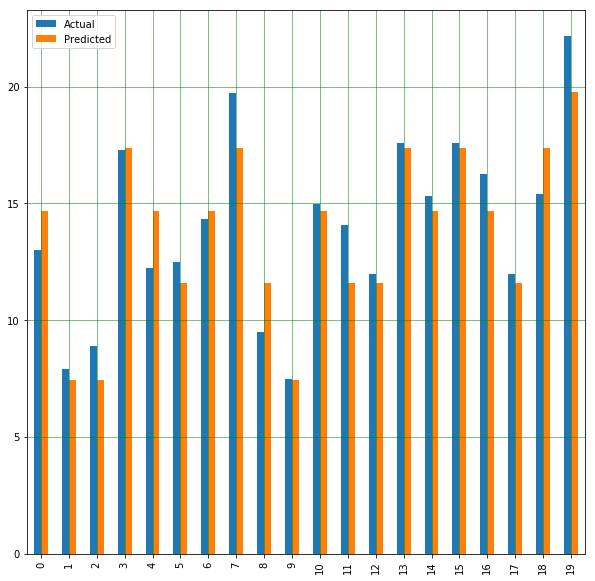

In [23]:
#Data Visualization

#Take the two values for comparison as actual and predicted
pred_df = pd.DataFrame({'Actual': Y_test, 'Predicted': Y_pred})

#print the values
prd = pred_df.head(20)

#plot the values for comparison
prd.plot(kind='bar',figsize=(10,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()